In [ ]:
######################################################################################################
##########         피클 데이터를 이용하려면 아래 코드부터 실행하면 됨.                   ################
######################################################################################################

In [2]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
import pickle

with open('oxt_data_img_cnn.pkl', 'rb') as f1:
    oxt_data1=pickle.load(f1)
    
print("Read data proofing")
x_train=oxt_data1["x_train"]
t_train=oxt_data1['t_train']
x_test=oxt_data1['x_test']
t_test=oxt_data1['t_test']

print(x_train.shape, t_train.shape, x_test.shape, t_test.shape)

Read data proofing
(12000, 1, 28, 28) (12000,) (3000, 1, 28, 28) (3000,)


In [3]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]


In [4]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.optimizer import *

class Trainer:
    """신경망 훈련을 대신 해주는 클래스
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = int(max(self.train_size / mini_batch_size, 1))
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
            
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))
            



In [5]:
# coding: utf-8
#import sys, os
#sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt

from dataset.img_oxt import load_oxt
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_oxt(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=3, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

이미지 갯수: 15000 ( 5000 5000 5000 )
15000
0
1
2
train loss:0.814686461774607
=== epoch:1, train acc:0.484, test acc:0.483 ===
train loss:0.7656378962462853
train loss:0.6959002713612762
train loss:0.5768914385221158
train loss:0.5214377725455764
train loss:0.45349782566458274
train loss:0.4521956894090257
train loss:0.585811991048049
train loss:0.6297156697877223
train loss:0.5466045038869692
train loss:0.433530030444762
train loss:0.5399220370849518
train loss:0.421568249092105
train loss:0.41988327696669253
train loss:0.32290571202690915
train loss:0.26151813430958926
train loss:0.30270655674496727
train loss:0.23169594960193382
train loss:0.20339085636565957
train loss:0.20980885587613934
train loss:0.18913918907226318
train loss:0.11920868311796266
train loss:0.19558788007177239
train loss:0.20436674038355984
train loss:0.2227591916718754
train loss:0.2408300467780943
train loss:0.29139909401008846
train loss:0.05230455289579945
train loss:0.22001710943591007
train loss:0.082981390300

train loss:0.019705115709283284
train loss:0.0024624531567743807
train loss:0.0006972917314697308
train loss:0.04042677008978556
train loss:0.0032099052467480355
train loss:0.0071439633241727
train loss:0.0021577967313708636
train loss:0.013336880093806913
train loss:0.0036644061269676814
train loss:0.006188847261375815
train loss:0.003929485157675297
train loss:0.002573214487594056
train loss:0.0012951155824098691
train loss:0.0021440451680750793
train loss:0.012255060899665366
train loss:0.005327317309982047
train loss:0.010051808836668395
train loss:0.0019872328363375004
train loss:0.0013165596728519527
train loss:0.0027717296194732376
train loss:0.01953841780985357
train loss:0.004941790995945466
train loss:0.007131936183365777
train loss:0.019403068105890563
train loss:0.007966058119628822
train loss:0.02056068626514874
train loss:0.003199529328060486
train loss:0.007665897193160771
train loss:0.0006180461514632966
train loss:0.004868417317169564
train loss:0.0018330737154951132
t

train loss:0.0008192308996536178
train loss:0.0028428193867075804
train loss:0.0034948800413741083
train loss:0.0015920283653236998
train loss:0.0011223218361350092
train loss:0.0011169437490842029
train loss:0.0003481027280666645
train loss:0.0008392638243940743
train loss:0.0011199646951016858
train loss:0.004127529211005756
train loss:0.0008778426266067963
train loss:0.0004741346647366874
train loss:0.000701240581924936
train loss:0.00124529139113265
train loss:0.0001289664424773388
train loss:0.0009600818177519236
train loss:0.0009091787295714872
train loss:0.0006888359300027075
train loss:0.0012315036339844924
train loss:0.0007081572585567309
train loss:0.0013351525400322037
train loss:0.0005849507742794459
train loss:0.0009377522691588331
train loss:0.0005559412240914928
train loss:0.0005534743352670515
train loss:0.0029058190981585087
train loss:0.0016637641877634646
train loss:0.0008521383300495345
train loss:0.0008300754975225913
train loss:0.0013833002501402896
train loss:0.0

train loss:4.3943393138180616e-05
train loss:0.00013361481466020578
train loss:0.0004016456022390694
train loss:0.0005572127794819819
train loss:0.00023274507298993503
train loss:0.00026767277697653486
train loss:0.0013091201475660622
train loss:0.0008675746673183616
train loss:0.0010811540461401728
train loss:4.861573215274466e-05
train loss:0.00029701739072214437
train loss:0.0005312465646257322
train loss:0.0002552295096314734
train loss:0.0005866690838344627
train loss:0.00029082268746391017
train loss:5.426745075724739e-05
train loss:3.15668548101456e-05
train loss:0.0005824040506379527
train loss:0.0002488168380593626
train loss:5.925050986998861e-05
train loss:0.00010449659429040031
train loss:3.155314904297456e-05
train loss:0.0004229008138072019
train loss:0.0006263812356644073
train loss:0.0001727043678090815
train loss:3.5288178240233653e-05
train loss:2.5507240359770287e-05
train loss:0.00021216070437065236
train loss:0.0005015060734677472
train loss:0.0007873931532369445
t

train loss:0.00011008004543561694
train loss:3.8738261223777466e-05
train loss:3.6471406586822895e-05
train loss:8.774714667700858e-05
train loss:2.9102865401894277e-05
train loss:1.4736344449845256e-05
train loss:1.352419485493397e-05
train loss:1.1265239505169513e-05
train loss:7.520508327829975e-06
train loss:6.199366929103947e-05
train loss:1.677025220343766e-05
train loss:7.515804595373043e-06
train loss:3.268371173580874e-06
train loss:0.00036769233730213075
train loss:9.890923297294825e-05
train loss:2.7434067253983268e-05
train loss:1.577994575413721e-05
train loss:0.00031358265520546017
train loss:0.00017421417174178888
train loss:5.343178802823424e-06
train loss:1.3076085823997086e-05
train loss:1.441684509157251e-05
train loss:7.38974665583591e-05
train loss:0.00015360535194355526
train loss:6.320040148355652e-05
train loss:1.509214689709476e-05
train loss:3.4814081481167864e-05
train loss:0.0003248577021070708
train loss:2.2490959955746912e-05
train loss:0.00014152120974256

train loss:8.141434318895998e-06
train loss:7.222900894552356e-05
train loss:6.319214111421429e-06
train loss:1.2829638952526947e-05
train loss:2.3237454582462026e-05
train loss:0.00010255338042267706
train loss:4.205725964429424e-05
train loss:4.436346893307123e-05
train loss:1.341046928934463e-05
train loss:8.86863984635571e-06
train loss:0.0006146404988343898
train loss:4.041825520693788e-05
train loss:8.651473514318823e-05
train loss:8.25395760422512e-05
train loss:2.3393562262180064e-05
train loss:9.128266894305127e-05
train loss:0.00030955637491069575
train loss:2.298813516404001e-05
train loss:1.4571152444845413e-05
train loss:1.5233215670438966e-05
train loss:6.023375175324794e-06
train loss:2.9101327870077664e-05
train loss:0.0006284134918370154
train loss:1.4669156055600183e-05
train loss:0.00041329346041781234
train loss:0.00026244041934920056
train loss:0.00015026806979641616
train loss:9.777535746799777e-05
train loss:2.8403363051792472e-05
train loss:0.0004284949759797913

train loss:0.0005197309713307888
train loss:0.0026010925600146216
train loss:0.0345365941077595
train loss:0.0001567669950305539
train loss:0.0024600564260678316
train loss:0.0002708636598243861
train loss:0.00011692740709466543
train loss:0.0004836114881893861
train loss:0.004638047385545101
train loss:0.004956470408676403
train loss:0.00317544900402083
train loss:0.0021011170586759127
train loss:0.004818938723326876
train loss:0.0024799279929942847
train loss:0.0013792387307775536
train loss:0.0016206727827200937
train loss:0.0005038886770033641
train loss:0.00011828523055304338
train loss:0.0001276554317399174
train loss:0.002331375951999719
train loss:0.0003609436685682281
train loss:0.0002606625724231204
train loss:0.0011271786605547296
train loss:0.0026971913711938
train loss:0.000642946870637066
train loss:0.00012046918318107804
train loss:0.0006718651057947956
train loss:0.00021964448401130303
train loss:0.00047931312950602904
train loss:8.241743976595716e-05
train loss:0.00021

train loss:4.618620670914746e-05
train loss:0.0005488456353902573
train loss:0.0008631936563496086
train loss:0.00019077470136054465
train loss:0.0005981561004452685
train loss:0.00032147835129062966
train loss:1.955485680325301e-05
train loss:0.00012276299947436699
train loss:0.0002940439724960047
train loss:0.0005969628280073486
train loss:7.763568211631216e-05
train loss:0.00023933454447342024
train loss:0.00024721661011539454
train loss:0.00021165145863735534
train loss:3.144026706025581e-05
train loss:0.0004790534429917314
train loss:2.0319684050512723e-05
train loss:0.00029681367494389975
train loss:0.0002113170678789061
train loss:2.053812622376397e-05
train loss:0.00012408320835751514
train loss:5.2079690116981906e-05
train loss:4.492694980710843e-05
train loss:0.00010265395029551823
train loss:0.00010418725551852612
train loss:0.00010334369393910444
train loss:0.00011139354334561619
train loss:1.2820750794440759e-05
train loss:0.000605448003587722
train loss:0.0001899484491787

train loss:1.2006182790931312e-07
train loss:0.0004655568046214671
train loss:0.0005264279469735965
train loss:1.0507827828904611e-07
train loss:0.0002433860058863053
train loss:6.328493429149336e-05
train loss:0.0002359499992717253
train loss:1.383738422488322e-06
train loss:0.0003617663369143865
train loss:2.5445235955167325e-06
train loss:0.00038346244433440797
train loss:4.440627104941146e-05
train loss:5.554042687321563e-05
train loss:3.0367192975602514e-06
train loss:7.207980157304124e-05
train loss:0.0011852631429440706
train loss:0.0004555695901524238
train loss:0.0003226585210404565
train loss:0.00041788693119255445
train loss:6.124354404139554e-06
train loss:8.900029649542467e-05
train loss:8.159016138017732e-05
train loss:3.500316094065241e-07
train loss:4.668533885675003e-06
train loss:1.044127849782184e-05
train loss:0.00022494013695359007
train loss:0.00014009122593419207
train loss:2.6787564913159687e-05
train loss:6.513262640823395e-06
train loss:0.00046455582819740395


train loss:1.0702524900357005e-08
train loss:3.823527153071643e-06
train loss:0.0003346820317610416
train loss:4.410754599121839e-06
train loss:7.810621442506365e-06
train loss:7.735725894834024e-05
train loss:3.71275895826831e-06
train loss:5.128575813601718e-05
train loss:8.004655643248213e-06
train loss:1.0795733228013437e-05
train loss:5.75537513323174e-05
train loss:6.816748924008035e-05
train loss:9.22403980319443e-06
train loss:0.0002878045521858771
train loss:0.000388414188833697
train loss:6.50915205717931e-05
train loss:5.205936107891944e-05
train loss:1.4903392849680201e-05
train loss:9.715356853354124e-07
train loss:9.159368510434142e-05
train loss:4.146488261342566e-06
train loss:2.9652217997983144e-07
train loss:0.0003260963158662892
train loss:2.3249311041780117e-06
train loss:7.027044086205254e-05
train loss:0.00030516553918056617
train loss:1.8428518972027658e-06
train loss:1.1934426444955835e-05
train loss:3.0279709258159847e-07
train loss:9.191373233607336e-05
train 

In [9]:
print(network.params['W3'])

[[ 0.03690452 -0.02553347 -0.02966439]
 [-0.04931898  0.02581714  0.00199626]
 [-0.00385304 -0.00971032  0.00247456]
 [ 0.01723339 -0.00789018 -0.02008049]
 [ 0.01818325  0.00967089 -0.01005577]
 [ 0.01891191 -0.02157375  0.01440606]
 [ 0.00142917 -0.01088221  0.00320727]
 [ 0.00339241 -0.00830942 -0.00443222]
 [-0.01572326 -0.03055921  0.01140681]
 [-0.0237182   0.02981972 -0.01778364]
 [-0.02056431  0.0229232  -0.00356232]
 [ 0.00670577 -0.00418313 -0.01539559]
 [-0.0088091  -0.01350517  0.00089155]
 [ 0.00253032  0.0174236  -0.0196501 ]
 [ 0.00333909 -0.02016207  0.00327266]
 [-0.0153515   0.02221197 -0.02404533]
 [-0.0018285   0.01510665  0.01572447]
 [-0.01398969 -0.01159235  0.00690803]
 [ 0.02502679 -0.0218316  -0.03932124]
 [-0.01116856  0.01743012 -0.00847071]
 [ 0.00728166  0.01857383 -0.03540851]
 [-0.01451886  0.00535431  0.00806812]
 [ 0.00618735 -0.00242594 -0.01854552]
 [-0.00246742 -0.00862445  0.01927796]
 [ 0.0109034  -0.01581386 -0.0069982 ]
 [-0.02833144  0.02202723

In [10]:
print(trainer.train_acc_list, trainer.test_acc_list)

[0.567, 0.961, 0.986, 0.995, 0.999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [0.57, 0.9566666666666667, 0.9716666666666667, 0.9883333333333333, 0.9883333333333333, 0.985, 0.99, 0.9883333333333333, 0.9883333333333333, 0.9883333333333333, 0.9883333333333333, 0.9883333333333333, 0.9883333333333333, 0.9883333333333333, 0.9883333333333333, 0.9883333333333333, 0.9883333333333333, 0.9883333333333333, 0.9883333333333333, 0.9883333333333333]


Saved Network Parameters!


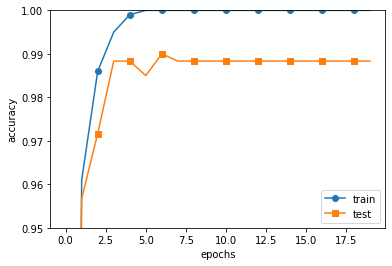

In [11]:
import matplotlib.pyplot as plt

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0.95, 1.0)
plt.legend(loc='lower right')
plt.show()

In [2]:
## load_parameter를 이용해 학습을 시키지 않고 이전 파리미터값을 이용.

# coding: utf-8
#import sys, os
#sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
#import numpy as np

from dataset.oxt import load_oxt
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test)=load_oxt(flatten=False)

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=3, weight_init_std=0.01)

network.load_params("params.pkl")

ModuleNotFoundError: No module named 'simple_convnet'

In [17]:
# 테스트 데이터 생성 o, x, t
# 도형을 그리고 아무 키를 누르면 myImg.png로 저장
# 그린 도형을 예측해서 결과 출력
import sys
import numpy as np
import cv2


oldx = oldy = -1

def on_mouse(event, x, y, flags, param):
    global oldx, oldy

    if event == cv2.EVENT_LBUTTONDOWN:
        oldx, oldy = x, y
        # print('EVENT_LBUTTONDOWN: %d, %d' % (x, y))

    # elif event == cv2.EVENT_LBUTTONUP:
        # print('EVENT_LBUTTONUP: %d, %d' % (x, y))

    elif event == cv2.EVENT_MOUSEMOVE:
        if flags & cv2.EVENT_FLAG_LBUTTON:
            cv2.line(img, (oldx, oldy), (x, y), 0, 5, cv2.LINE_AA)
            cv2.imshow('image', img)
            oldx, oldy = x, y


img = np.ones((280, 280), dtype=np.uint8) * 255

cv2.namedWindow('image')
cv2.setMouseCallback('image', on_mouse, img)

cv2.imshow('image', img)
cv2.waitKey()

cv2.destroyAllWindows()
img = cv2.resize(img, (28,28), interpolation=cv2.INTER_AREA)     # 28*28 resize
img = ~img  # invert
cv2.imwrite('myImg.png', img)

#print(img.shape)
img=img.reshape(-1,1,28,28)
labels_view=['o', 'x', '△']
y=network.predict(img)
#print(y)
pred_num=np.argmax(y)
result = "my data image is %s"%(labels_view[pred_num])
print(result)

my data image is △


In [28]:
from tkinter import *
from PIL import ImageTk, Image
from tkinter import filedialog
import sys
import numpy as np
import cv2

window = Tk()
window.title('oxt 예측하기')
    
oldx = oldy = -1

def on_mouse(event, x, y, flags, param):
    global oldx, oldy

    if event == cv2.EVENT_LBUTTONDOWN:
        oldx, oldy = x, y
        # print('EVENT_LBUTTONDOWN: %d, %d' % (x, y))

    # elif event == cv2.EVENT_LBUTTONUP:
        # print('EVENT_LBUTTONUP: %d, %d' % (x, y))

    elif event == cv2.EVENT_MOUSEMOVE:
        if flags & cv2.EVENT_FLAG_LBUTTON:
            cv2.line(img, (oldx, oldy), (x, y), 0, 5, cv2.LINE_AA)
            cv2.imshow('image', img)
            oldx, oldy = x, y

def crt():
    global img, tmp_img
    img = np.ones((280, 280), dtype=np.uint8) * 255

    cv2.namedWindow('image')
    cv2.setMouseCallback('image', on_mouse, img)

    cv2.imshow('image', img)
    cv2.waitKey(3000)

    cv2.destroyAllWindows()
    
    img = cv2.resize(img, (28,28), interpolation=cv2.INTER_AREA)     # 28*28 resize
    cv2.imwrite('tmp.png', img)
    img = ~img  # invert
    img=img.reshape(-1,1,28,28)
    
    labels_view=['o', 'x', '△']

    y=network.predict(img)
    pred_num=np.argmax(y)
    result = "my predict is %s"%(labels_view[pred_num])
    
    tmp_img=Image.open('tmp.png')
    tmp_img=ImageTk.PhotoImage(tmp_img)
    
    Label(window, text="파일경로: new").grid(row=2) # 파일경로 view
    Label(window, image=tmp_img).grid(row=3) #사진 view
    Label(window, text=result).grid(row=4) # 예측 결과 출력    

def open():
    global my_image # 함수에서 이미지를 기억하도록 전역변수 선언 (안하면 사진이 안보임)
    window.filename = filedialog.askopenfilename(initialdir='', title='파일선택', filetypes=(
    ('png files', '*.png'), ('jpg files', '*.jpg'), ('all files', '*.*')))
 
    Label(window, text="파일경로: "+window.filename).grid(row=2) # 파일경로 view
    
    img = Image.open(window.filename)
    my_image = ImageTk.PhotoImage(img)
    
    img=img.convert("L")                         # gray 저장
    img=np.invert(img)                           # 흑백을 반전
    
    # print(img.shape)                           # img의 shape 확인
    img=img.reshape(-1, 1, 28, 28)
    
    Label(window, image=my_image).grid(row=3) #사진 view
    
    labels_view=['o', 'x', '△']

    y=network.predict(img)
    pred_num=np.argmax(y)
    result = "my predict is %s"%(labels_view[pred_num])
    Label(window, text=result).grid(row=4) # 예측 결과 출력
    

b_create=Button(window, text='그리기(아무키나 누르면 닫기)', command=crt).grid(row=0)
b_open = Button(window, text='파일열기', command=open).grid(row=1)
Label(window, text="파일 경로").grid(row=2)
Label(window).grid(row=3)
Label(window, text="예측 결과").grid(row=4)

window.mainloop()

In [1]:
import sys
import numpy as np
import cv2


model = 'opencv_face_detector/res10_300x300_ssd_iter_140000_fp16.caffemodel'
config = 'opencv_face_detector/deploy.prototxt'
#model = 'opencv_face_detector/opencv_face_detector_uint8.pb'
#config = 'opencv_face_detector/opencv_face_detector.pbtxt'

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print('Camera open failed!')
    sys.exit()

net = cv2.dnn.readNet(model, config)

if net.empty():
    print('Net open failed!')
    sys.exit()

while True:
    ret, frame = cap.read()

    if not ret:
        break

    blob = cv2.dnn.blobFromImage(frame, 1, (300, 300), (104, 177, 123))
    net.setInput(blob)
    out = net.forward()

    detect = out[0, 0, :, :]
    (h, w) = frame.shape[:2]

    for i in range(detect.shape[0]):
        confidence = detect[i, 2]
        if confidence < 0.5:
            break

        x1 = int(detect[i, 3] * w)
        y1 = int(detect[i, 4] * h)
        x2 = int(detect[i, 5] * w)
        y2 = int(detect[i, 6] * h)

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0))

        label = f'Face: {confidence:4.2f}'
        cv2.putText(frame, label, (x1, y1 - 1), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1, cv2.LINE_AA)

    cv2.imshow('frame', frame)

    if cv2.waitKey(1) == 27:
        break

cv2.destroyAllWindows()

Camera open failed!


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
